Hyperparameter tuned, uses raw_data with Guassian noise.

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import keras
import tensorflow  as tf 

import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
import keras_tuner

In [2]:
try:
    for dirname, _, filenames in os.walk('ECG/inputs/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
except Exception as e:
    print(f"An error occurred: {e}")

ECG/inputs/dataECG\mitbih_test.csv
ECG/inputs/dataECG\mitbih_train.csv
ECG/inputs/dataECG\ptbdb_abnormal.csv
ECG/inputs/dataECG\ptbdb_normal.csv


In [3]:
train_data = pd.read_csv('ECG/inputs/dataECG/mitbih_train.csv', header=None)
test_data = pd.read_csv('ECG/inputs/dataECG/mitbih_test.csv',header=None)


Split target and value

In [4]:
train_target = train_data[187]
test_target  = test_data [187]
train = train_data.drop(187,axis=1)
test = test_data.drop(187,axis=1)

In [5]:
expl_mitbih_train = train_target.copy()

In [6]:
expl_mitbih_test = test_target.copy()

In [7]:
expl_train = expl_mitbih_train.astype(int)

explor_train = expl_train.value_counts()

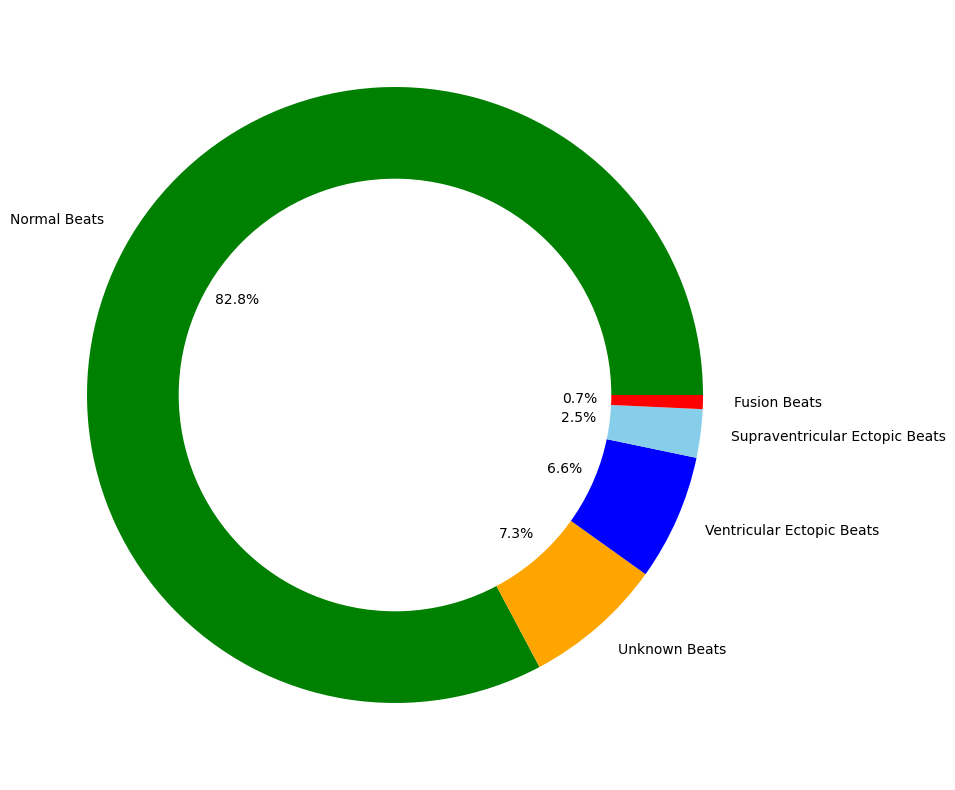

In [8]:
plt.figure(figsize = (10, 10))
circle = plt.Circle((0, 0), 0.7, color = "white")
plt.pie(explor_train, labels = ["Normal Beats", "Unknown Beats", "Ventricular Ectopic Beats", "Supraventricular Ectopic Beats", "Fusion Beats"], colors = ["green", "orange", "blue", "skyblue", "red"], autopct = "%1.1f%%")
k = plt.gcf()
k.gca().add_artist(circle)
plt.show()

In [9]:
classes = train_data.groupby(187, group_keys = False).apply(lambda train_data : train_data.sample(1))

In [10]:
y_train = to_categorical(expl_mitbih_train)

y_test = to_categorical(expl_mitbih_test)

In [11]:
x_train = train_data.iloc[ : ,  : 186].values
x_test = test_data.iloc[ : ,  : 186].values

In [12]:
np.random.seed (100)

def add_noise(signal):
    gaussian_noise = np.random.normal(0.2, 0.5, 186)
    noissy_signal = signal + gaussian_noise
    return noissy_signal

In [13]:
for k in range(len(x_train)):
    x_train[k, : 186] = add_noise(x_train[k, : 186])
x_train = x_train.reshape(len(x_train), x_train.shape[1], 1)
x_test = x_test.reshape(len(x_test), x_test.shape[1], 1)

Residual Block

In [14]:
def residual_block(x, filters, kernel_size = 5, strides = 1):
    # Shortcut connection
    shortcut = x
    
    # First convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = GlorotUniform())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = GlorotUniform())(x)
    x = BatchNormalization()(x)
    
    # Adjusting the shortcut connection with a 1x1 convolution
    shortcut = Conv1D(filters, kernel_size = 1, strides = strides, padding = "same")(shortcut)
    
    # Adding the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation("selu")(x)
    
    return x

In [15]:
input_shape = (x_train.shape)
class_num = len(classes)

In [16]:
class_num

5

In [17]:
input_shape = (x_train.shape[1], 1)

#input_shape = tf.keras.Input(shape = input)

In [18]:
def build_model(hp):

    input_shape = (x_train.shape[1], 1)
    class_num = len(classes)
    model = tf.keras.Sequential()
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Convolutional layers
    x = tf.keras.layers.Conv1D(
        filters = 64,
        kernel_size = 6,
        strides = 2,
        padding="same",
        kernel_initializer = tf.keras.initializers.GlorotUniform()
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("selu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size = 3, padding = "same")(x)

    # Residual blocks
    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 64)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 128)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    x = residual_block(x, filters = 256)
    x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)

    # Flatten layer
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    for i in range(hp.Int("num_dense_layers", 1, 3)):
        x = tf.keras.layers.Dense(
            units = hp.Int(f"units_dense_{i}", min_value=32, max_value = 512, step = 32),
            activation = hp.Choice("activation_dense", ["relu", "selu"])
        )(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    # Output layer
    model_output = tf.keras.layers.Dense(class_num, activation = "softmax")(x)

    # Compile the model
    model = tf.keras.Model(inputs = input_layer, outputs = model_output)
    learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 2e-2, sampling = "log")
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model


In [19]:
build_model(keras_tuner.HyperParameters())

In [20]:
input_shape = (x_train.shape[1], 1)


In [21]:
class_num

5

In [22]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 3,
    executions_per_trial = 2,
    overwrite = True,
    directory = "./",
    project_name = "mitbih_tuned",
)

In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_residual_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
Dropout_Residual_Blocks (Boolean)
{'default': False, 'conditions': []}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.02, 'step': None, 'sampling': 'log'}


In [24]:
tuner.search(
    x_train, y_train, 
    epochs = 3, 
    validation_data = (x_test, y_test),
    callbacks = [keras.callbacks.TensorBoard("./tbb_logs")]
    )

Trial 3 Complete [00h 18m 16s]
val_accuracy: 0.8709345757961273

Best val_accuracy So Far: 0.8709345757961273
Total elapsed time: 00h 47m 21s


In [25]:
%load_ext tensorboard

%tensorboard --logdir ./tbb_logs

In [26]:
models = tuner.get_best_models(num_models = 2)
best_model = models[0]

In [27]:
tuner.results_summary()

Results summary
Results in ./mitbih_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
num_residual_blocks: 4
Dropout_Residual_Blocks: False
num_dense_layers: 3
units_dense_0: 32
activation_dense: relu
learning_rate: 0.0019391558813846572
units_dense_1: 64
units_dense_2: 96
Score: 0.8709345757961273

Trial 1 summary
Hyperparameters:
num_residual_blocks: 3
Dropout_Residual_Blocks: True
num_dense_layers: 3
units_dense_0: 64
activation_dense: relu
learning_rate: 0.003621514631815843
units_dense_1: 288
units_dense_2: 448
Score: 0.835944652557373

Trial 0 summary
Hyperparameters:
num_residual_blocks: 2
Dropout_Residual_Blocks: True
num_dense_layers: 3
units_dense_0: 512
activation_dense: relu
learning_rate: 0.018789635497030416
units_dense_1: 32
units_dense_2: 32
Score: 0.8276082873344421


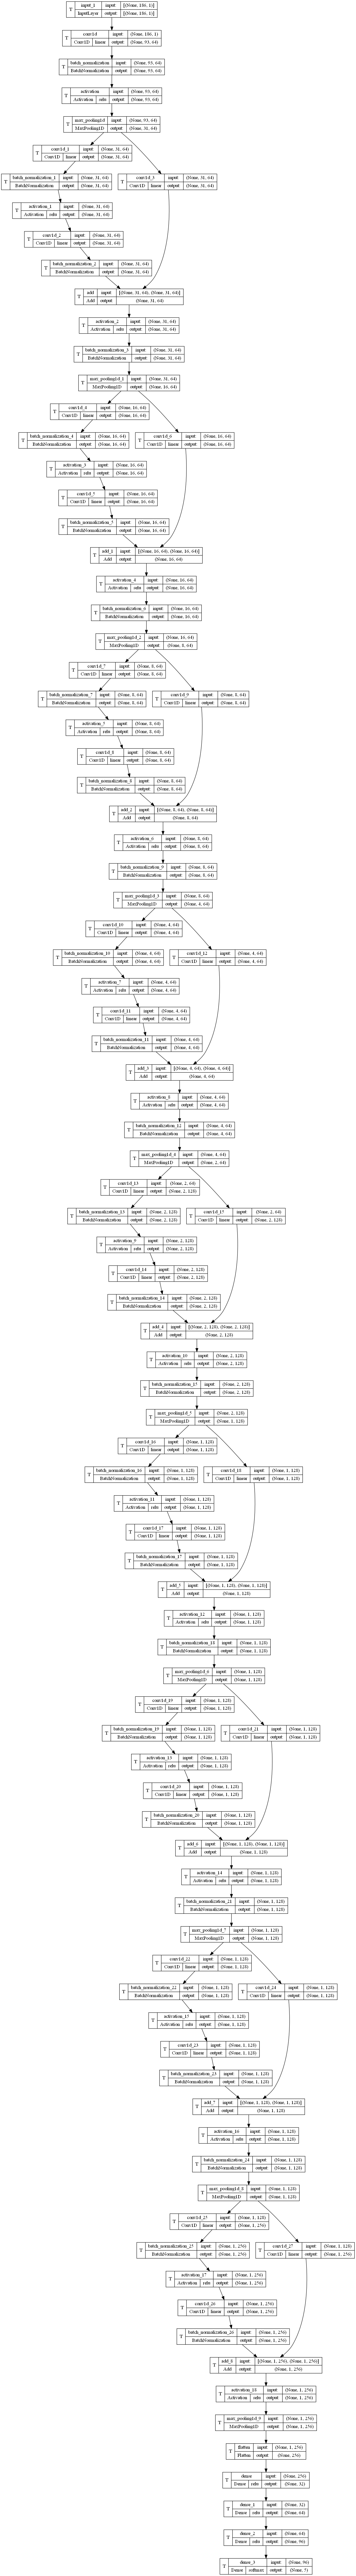

In [29]:
tf.keras.utils.plot_model(best_model,
                          to_file='modelv02.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

In [30]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 186, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 93, 64)               448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 93, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 93, 64)               0         ['batch_normalization[0][0

`Training the Best model with the entire dataset again`

In [32]:
history = best_model.fit(
    x_train, y_train, 
    epochs = 10, 
    validation_data = (x_test, y_test),
    batch_size = 32,
    callbacks = [keras.callbacks.TensorBoard("./tbb1_logs")]
    )

Epoch 1/10
2737/2737 [==============================] - 141s 51ms/step - loss: 0.3776 - accuracy: 0.8859 - val_loss: 0.5322 - val_accuracy: 0.8704
Epoch 2/10
2737/2737 [==============================] - 145s 53ms/step - loss: 0.3682 - accuracy: 0.8887 - val_loss: 0.4750 - val_accuracy: 0.8675
Epoch 3/10
2737/2737 [==============================] - 146s 53ms/step - loss: 0.3590 - accuracy: 0.8912 - val_loss: 0.4450 - val_accuracy: 0.8762
Epoch 4/10
2737/2737 [==============================] - 150s 55ms/step - loss: 0.3481 - accuracy: 0.8934 - val_loss: 0.4842 - val_accuracy: 0.8705
Epoch 5/10
2737/2737 [==============================] - 149s 54ms/step - loss: 0.3396 - accuracy: 0.8956 - val_loss: 0.5000 - val_accuracy: 0.8695
Epoch 6/10
2737/2737 [==============================] - 153s 56ms/step - loss: 0.3313 - accuracy: 0.8978 - val_loss: 0.5551 - val_accuracy: 0.8611
Epoch 7/10
2737/2737 [==============================] - 159s 58ms/step - loss: 0.3214 - accuracy: 0.9007 - val_loss: 0

In [33]:
%load_ext tensorboard

%tensorboard --logdir ./tbb1_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [34]:
def model_plots(history):
    """ This function plots the model accuracy and loss. """
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()


    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()

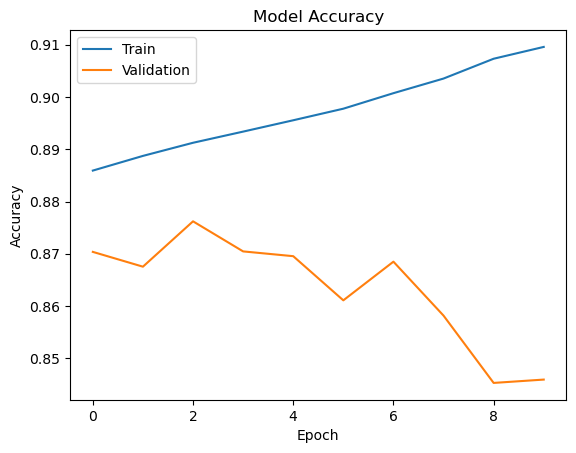

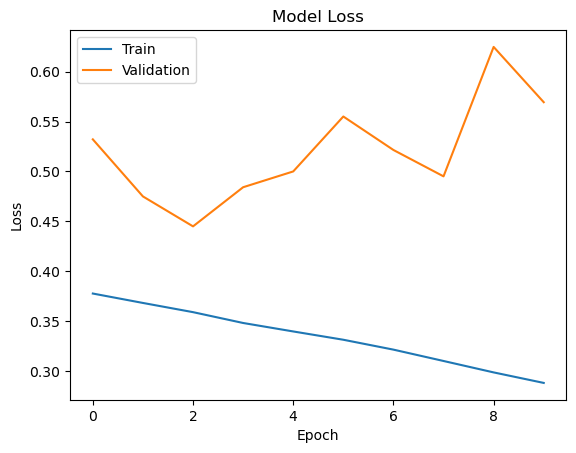

In [35]:
model_plots(history = history)

In [36]:
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy is: {accuracy} and Test Loss is: {loss}")

685/685 [==============================] - 7s 10ms/step - loss: 0.5694 - accuracy: 0.8459
Test Accuracy is: 0.8459254503250122 and Test Loss is: 0.5694200992584229


In [37]:
y_pred = best_model.predict(x_test)

685/685 [==============================] - 10s 11ms/step


In [48]:
def plot_confusion_matrix (model, x_test, y_test, class_names):
    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_classes)

    plt.figure(figsize = (10, 10))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = class_names, yticklabels = class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))

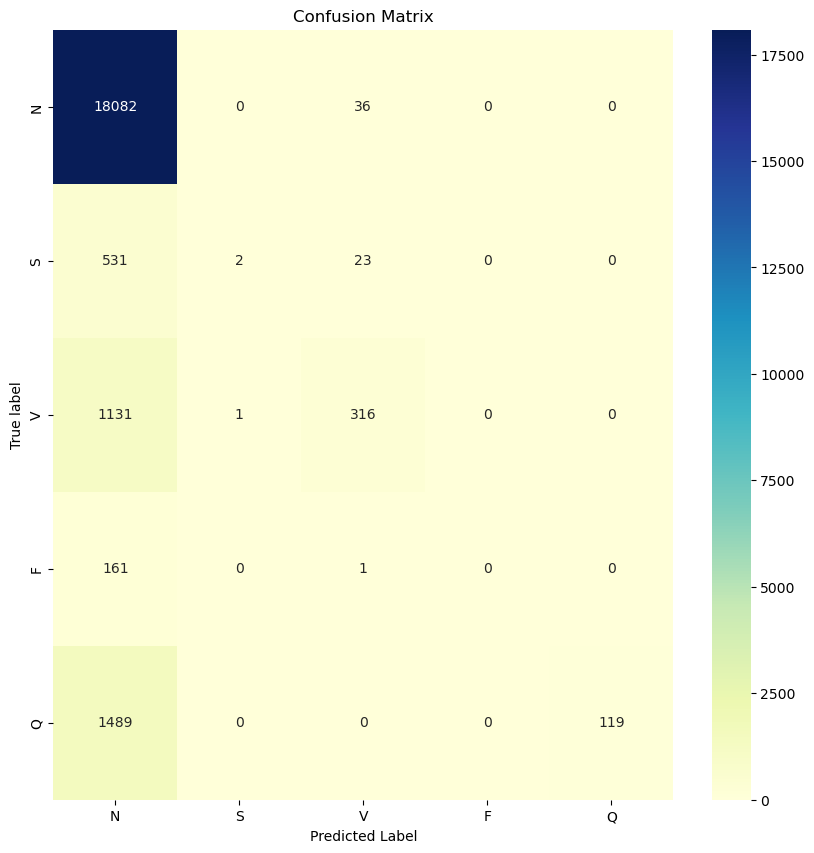

              precision    recall  f1-score   support

           N       0.85      1.00      0.92     18118
           S       0.67      0.00      0.01       556
           V       0.84      0.22      0.35      1448
           F       0.00      0.00      0.00       162
           Q       1.00      0.07      0.14      1608

    accuracy                           0.85     21892
   macro avg       0.67      0.26      0.28     21892
weighted avg       0.85      0.85      0.79     21892



c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
class_names = ["N", "S", "V", "F", "Q"]

plot_confusion_matrix(best_model, x_test, y_test, class_names)

In [54]:
def plot_confusion_matrix(classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
    np.set_printoptions(precision = 2)
    
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    
    
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))


Normalized confusion matrix


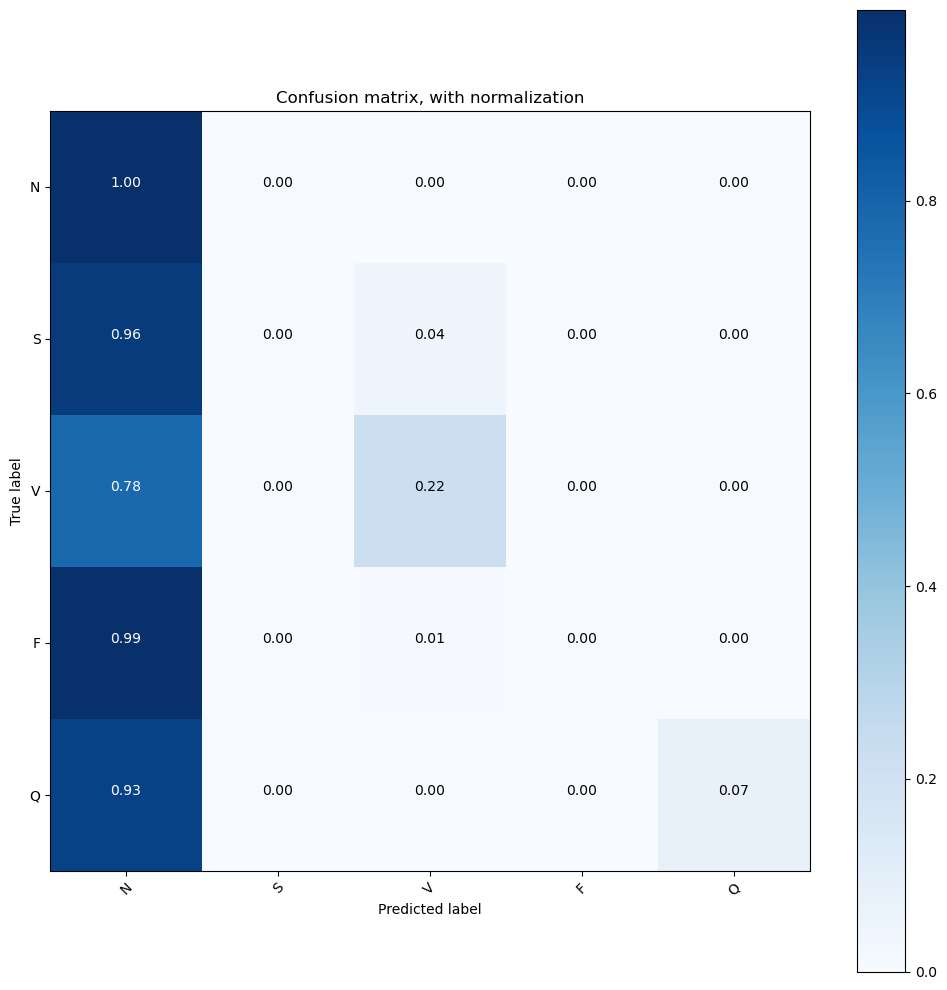

              precision    recall  f1-score   support

           N       0.85      1.00      0.92     18118
           S       0.67      0.00      0.01       556
           V       0.84      0.22      0.35      1448
           F       0.00      0.00      0.00       162
           Q       1.00      0.07      0.14      1608

    accuracy                           0.85     21892
   macro avg       0.67      0.26      0.28     21892
weighted avg       0.85      0.85      0.79     21892



c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
plot_confusion_matrix(classes = class_names, normalize = True,
                      title="Confusion matrix, with normalization")
